# 5 | Assignment: Model fitting with singular value decomposition
**ES143 Computer Vision, Harvard University**

Name: *(<font color=red>Sedik Sadik</font>)*

<br>

---

In this assignment you will learn to:
*  use singular value decomposition for geometric model-fitting tasks, by formulating them as homogeneous least-squares problems
*  use singular value decomposition to analyze fitting problems that are both under-constrained and over-constrained

If you have not already done so, begin by creating a copy of this notebook in your google drive at filepath

`My Drive/es-143-assignments/M05/*`

Small items marked with "<font color='red'>**To Do**</font>" require you to act and think but will not be evaluated. Sections marked with "<font color='red'>**TASK ##**</font>" will be evaluated.

---

When you are done, double-check that your notebook runs without error (i.e., `Restart session and run all`) and then generate an HTML file by the running the *Submission* cells [at the bottom of the notebook](#submission). Double-check that all images have been rendered correctly in your HTML file, and then submit the HTML and `.ipynb` version of your notebook to Canvas with filenames of the form `LASTNAME_FIRSTNAME_M05-ModelFitting-SVD.{html,ipynb}`.

As usual, use of generative AI tools must adhere to the course policy as described in the [ES 143 Syllabus](https://canvas.harvard.edu/courses/129415/assignments/syllabus). In particular:
* You may not submit AI-generated code that you cannot explain, or whose validity and correctness you have not verified.
* Your use of generative AI tools must be documented in [the usual text cell](#ai-disclosure) near the bottom of the notebook.

---

## Setup

The next few cells mount your Google drive and import some useful packages and configure figure sizes. They also define two helper functions to convert between inhomogeneous and homogeneous 2D coordinates.

In [1]:
# # Mount your google drive. This will launch a pop-up window for authentication.

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# YOU SHOULD HAVE ALREADY COPIED THE ASSIGNMENT FILES TO THIS
# FOLDER ON YOUR GOOGLE DRIVE

# %cd "/content/drive/My Drive/es-143-assignments/M05/"

In [3]:
# Import required libraries
import cv2                # OpenCV
import numpy as np        # numpy

# Use this to reduce precision when printing floats (for tidiness)
np.set_printoptions(precision=2)

# Use this to make plots static and non-interactive
# (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt

#### Helper functions: `in2hom()` and `hom2in()`

For a set of N points in two dimensions, here are two functions to convert between inhomogeneous coordinates ($Nx2$ array, with rows $(x_i,y_i)$) and homogeneous coordinates ($N\times 3$ array, with rows proportional to $(x_i,y_i,1)$).

In [4]:
# Convert from Nx2 inhomogeneous to Nx3 homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from Nx3 homogeneous to Nx2 inhomogeneous coordinates
def hom2in(X):
    return X[:, :2] / X[:, 2:]

# Section 1. Fitting a Line

Following Hartley and Zisserman, we use notation $\tilde{\bf x}=(x,y)$ for the inhomogeneous coordinates of an image point, and we use ${\bf x}= (x,y,1)$ for the corresponding homogeneous coordinates (which are defined up to scale). A line in the image is represented by homogeneous vector $\boldsymbol{l}=(a,b,c)$.

Our input is a set of $N$ points, $\tilde{\bf x}_i=(x_i,y_i),i=1\ldots N$, and we want to find a line $\boldsymbol{l}$ that fits the points well.

As a learning tool, imagine a $100\times 100$ image in which a set of 2D points has been detected and reported by an $N\times 2$ array `X` of their 2D inhomogeneous pixel coordinates.

In this section of the notebook, you will investigate the effects of manipulating the input 2D point-set and fitting lines. To help visualize these effects, the following cell defines a function

`fig,ax = mylineplot(points=X, line=l, axes=ax)`

that you will use to plot the input points and the fitted line(s) in an image-like way. The optional input `axes` determines whether the function creates a new plot or adds the points and/or lines to an existing plot.

The following cell includes a demonstration of how to use this plotting function to: (i) draw a new figure with points and a line, and (ii) add a line to an existing figure.

---
<font color='red'>**To do**</font>: It is not necessary for you to understand what's inside the function, but it is important that you know how to use it. Run the cell and study the cell's final ten lines of code. Try plotting different lines and get feel for how it works.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

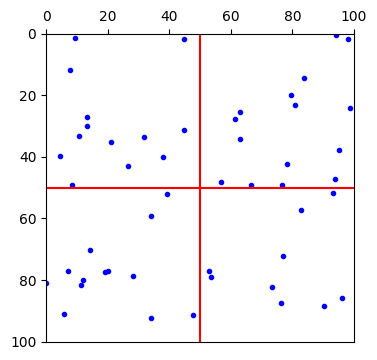

In [5]:
#@title Demonstration: `mylineplot()`

def mylineplot(**kwargs):
    """
    Usage: fig,ax = mylineplot(points=X, line=l, axes=ax, imsize=w)

    Parameters:
      X   -- Nx2 numpy array of inhomogeneous (x,y) point coordinates
      l   -- 1x3 vector of line coordinates (a,b,c)
      ax  -- plt.axes object (if absent, a new figure is created)
      w   -- width of square image in pixels

    Returns:
      fig -- matplotlib figure object
      ax  -- matplotlib axes object

    Notes:
      To plot a line, this function uses the trick of drawing the zero-valued
      contour of the algebraic function $h(x,y)=ax+by+c$ using
      matplotlib.pyplot.contour(). Thanks to Modesto Mas for the idea
      (see https://mmas.github.io/conics-matplotlib))
    """

    # if no imsize is provided, set it to 100
    if 'imsize' in kwargs:
        imsize=kwargs.get("imsize")
    else:
        imsize = 100

    # if no axes object provided, create new figure and axes
    if 'axes' in kwargs:
        ax=kwargs.get("axes")
        fig=ax.figure
        ax.set_aspect(aspect=1)
        ax.set_xlim([0, imsize])
        ax.set_ylim([0, imsize])
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    else:
        fig, ax = plt.subplots(figsize=(4,4))

        # make axes "image-like", with origin (0,0) in the top-left corner
        ax.set_aspect(aspect=1)
        ax.set_xlim([0, imsize])
        ax.set_ylim([0, imsize])
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # plot points
    if 'points' in kwargs:
        pts=kwargs.get("points")
        ax.plot(pts[:, 0], pts[:, 1], 'b.')

    # plot line using zero-value contour of h(x,y)=ax+by+c
    if 'line' in kwargs:
        line=kwargs.get("line")
        x,y=np.meshgrid(np.linspace(0,imsize,imsize*5),np.linspace(0,imsize,imsize*5))
        ax.contour(x, y, line[0]*x+line[1]*y+line[2], [0], colors='r')

    return fig,ax

# define image size
image_width = 100

# define 50 random points in square [0,image_width]x[0,image_width]
X = np.random.rand(50, 2) * image_width


# define a horizontal line through middle of image_width
lh=[0,1,-image_width/2]

# define a vertical line through middle of image_width
lv=[1,0,-image_width/2]

# plot points and line in a new figure
f,ax = mylineplot(points=X, line=lh, imsize=image_width)

# add a line to the existing figure
mylineplot(line=lv, axes=ax, imsize=image_width)

In [6]:
import math
def batman():
    Y = np.arange(-4,4,.005)
    X = np.zeros((0))
    for y in Y:
        X = np.append(X,abs(y/2)- 0.09137*y**2 + math.sqrt(1-(abs(abs(y)-2)-1)**2) -3)
    
    Y1 = np.append(np.arange(-7,-3,.01), np.arange(3,7,.01))
    X1 = np.zeros((0))
    for y in Y1:
        X1 = np.append(X1, 3*math.sqrt(-(y/7)**2+1))
    X = np.append(X,X1)
    Y = np.append(Y, Y1)
    Y1 = np.append(np.arange(-7.,-4,.01), np.arange(4,7.01,.01))
    X1 = np.zeros((0))
    for y in Y1:
        X1 = np.append(X1, -3*math.sqrt(-(y/7)**2+1))
    X = np.append(X,X1)
    Y = np.append(Y, Y1)
    Y1 = np.append(np.arange(-1,-.8,.01), np.arange(.8, 1,.01))
    X1 = np.zeros((0))
    for y in Y1:
        X1 = np.append(X1, 9-8*abs(y))
    X = np.append(X,X1)
    Y = np.append(Y, Y1)
    Y1 = np.arange(-.5,.5,.05)
    X1 = np.zeros((0))
    for y in Y1:
        X1 = np.append(X1,2)
    X = np.append(X,X1)
    Y = np.append(Y, Y1)
    Y1 = np.append(np.arange(-2.9,-1,.01), np.arange(1, 2.9,.01))
    X1 = np.zeros((0))
    for y in Y1:
        X1 = np.append(X1, 1.5 - .5*abs(y) - 1.89736*(math.sqrt(3-y**2+2*abs(y))-2) )
    X = np.append(X,X1)
    Y = np.append(Y, Y1)
    Y1 = np.append(np.arange(-.7,-.45,.01), np.arange(.45, .7,.01))
    X1 = np.zeros((0))
    for y in Y1:
        X1 = np.append(X1, 3*abs(y)+.75)
    X = np.append(X,X1)
    Y = np.append(Y, Y1)
    X+=3
    Y+=7
    X*=35
    Y*=35
    return np.array([Y,X])

### <font color='red'>**Task 1A**</font>

Write code that uses `mylineplot()` to draw a simple "lines and points" picture of your own design. Your code should do this by defining a set of points and some lines of your choosing, and then making suitable calls to `mylineplot()` to draw them in a figure.

Your design should contain at least three lines and at least two points. Be creative.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

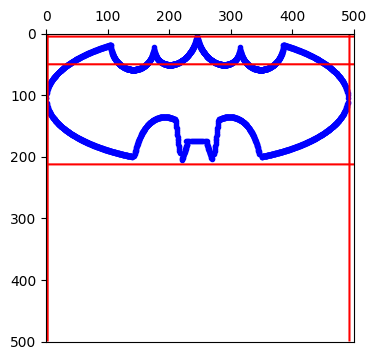

In [7]:
# define image size
image_width = 500

# define 50 random points in square [0,image_width]x[0,image_width]
X = np.random.rand(50, 2) * image_width



# plot points and line in a new figure
f,ax = mylineplot(points=(batman())[::,::-1].T, line=lh, imsize=image_width)
# add a line to the existing figure

lh=[0,1,-0.02*image_width/2]
mylineplot(line=lh, axes=ax, imsize=image_width)

lh=[0,1,-0.85*image_width/2]
mylineplot(line=lh, axes=ax, imsize=image_width)


# define a vertical line through middle of image_width
lv=[1,0,-0.01*image_width/2]
mylineplot(line=lv, axes=ax, imsize=image_width)

lv=[1,0,-1.97*image_width/2]
mylineplot(line=lv, axes=ax, imsize=image_width)

## Section 1.1. Two strategies for line-fitting

In class we dicussed two different strategies for solving the line-fitting problem.

1. Least squares. Set $b=1$ and find $(a, c)$ that most closely satisfy the
equations $y_i=-ax_i-c$, in a least-squares sense. This corresponds to finding
the line that minimizes the sum of squared vertical distances between the points and the line. We write this in matrix form as:
\begin{equation*}
\left.
\begin{array}{c}
-a x_1 - c = y_1 \\
-a x_2 - c = y_2 \\
\vdots \\
-a x_N - c = y_N
\end{array} \right\} \Rightarrow \underbrace{\begin{bmatrix}
-x_1 & -1 \\
-x_2 & -1 \\
\vdots & \vdots \\
-x_N & -1
\end{bmatrix}}_{\bf A} \cdot \underbrace{\begin{bmatrix}
a \\
c
\end{bmatrix}}_{\bf v} = \underbrace{\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_N
\end{bmatrix}}_{\bf b}
\end{equation*}
and define the least-squares objective
\begin{equation*}
\text{arg}\min_\mathbf{v}\|\mathbf{A}\mathbf{v}-\mathbf{b}\|^2.
\end{equation*}
The soluton to this program is described in Section A.2 (Linear least squares) of Szeliski, and in numpy we use `np.linalg.lstsq()`.

2. Find ${\bf l}=(a,\ b,\ c)$ that most closely satisfies the equations $ax_i+by_i+c=0$ by minimizing the sum $\sum_i\left({\bf l}^\top \mathbf{x}_i\right)^2$ with $\mathbf{x}_i\triangleq(x_i,y_i,1)$. We write this in matrix form as:
\begin{equation*}
\underbrace{\begin{bmatrix}
x_1 & y_1 & 1 \\
x_2 & y_2 & 1 \\
\vdots & \vdots \\
x_N & y_N & 1 \\
\end{bmatrix}}_{\bf A} \cdot \underbrace{\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}}_{\bf l} = \underbrace{\begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix}}_{\bf 0}
\end{equation*}
and define the homogeneous least-squares objective
\begin{equation*}
\text{arg}\min_{\bf l}\|\mathbf{A}{\bf l}\|^2\quad \text{such that } \|{\bf l}\|=1.
\end{equation*}
Note that the condition $\|{\bf l}\|=1$ is necessary in order to avoid the trivial solution ${\bf l}=(0,0,0)$. The solution to this program is described in Section A5.3 (Least-squares solution of homogeneous equations) of Hartley and Zisserman, and in numpy we use `np.linalg.svd()`.

The following cell contains functions that implement the two line-fitting strategies, <tt>fit_line_least_squares()</tt> and <tt>fit_line_homogeneous_least_squares()</tt>. Study them and make sure you understand how they work.

In [8]:
def fit_line_least_squares(X):
    """
    Input:
      X: Nx2 list of (x,y) points

    Returns:
      line: line parameters (a,b,c)
    """

    # separate the x and y coordinates for convenience
    x = X[:,0]
    y = X[:,1]

    # Construct the Nx2 "A matrix"
    A = -np.concatenate([x[:, np.newaxis], np.ones((x.size, 1))], axis=1)

    # Least squares solution
    l = np.linalg.lstsq(A, y, rcond=None)[0]

    # Format line as (a, b=1, c)
    return l[0], 1.0, l[1]

def fit_line_homogeneous_least_squares(X):
    """
    Input:
      X: Nx2 list of (x,y) points

    Returns:
      line: line parameters (a,b,c)
    """

    # Construct the Nx3 "A matrix" (this is equivalent to calling in2hom(X))
    A = np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

    # compute SVD, discarding U and D since we do not need them
    _, _, V = np.linalg.svd(A)

    # extract last column of V (note that np.linalg.svd() returns the transpose of V)
    l = V[2, :]

    return l

### <font color='red'>**Task 1B**</font>

The following cell defines three sets of four 2D points, `X1`, `X2`, `X3`, each a 4x2 matrix of [x,y] coordinates. It then calls functions `fit_line_least_squares()` and `fit_line_homogeneous_least_squares()` to fit two lines to each point-set and uses `mylineplot()` to display and compare the fitted lines.

Edit the coordinates of the three 2D points sets so that, when run, the cell convincingly demonstrates three different scenarios:
1. A set of four points `X1` for which the two methods produce the very same line estimates.
2. A set of four points `X2` for which the two methods produce different but similar line estimates.
3. A set of four points `X3` for which the two methods produce extremely different line estimates. (Hint: Consider the conditions in which the least-squares method fails.)

[[1 1]
 [2 2]
 [3 3]
 [4 4]]


Text(0.5, 0, 'Case 3: Different results')

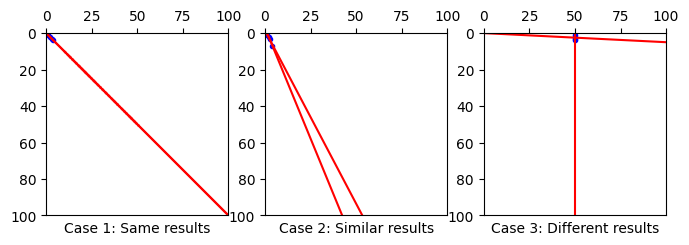

In [9]:
# Case 1: A set of four points X1 for which the methods give equal results
#
# TO DO: replace the following points with coordinates of your own choosing
X1=np.array([[1,1],
            [2,2],
            [3,3],
            [4,4]])
print(X1)

line1_ls  = fit_line_least_squares(X1)
line1_hls = fit_line_homogeneous_least_squares(X1)

# Case 2: A set of four points X2 for which the methods give different but similar results
#
# TO DO: replace the following points with coordinates of your own choosing
X2=np.array([[1,1],
            [2,2],
            [3,3],
            [4,7]])

line2_ls  = fit_line_least_squares(X2)
line2_hls = fit_line_homogeneous_least_squares(X2)

# Case 3: A set of four points X3 for which the methods give entirely different results
#
# TO DO: replace the following points with coordinates of your own choosing
X3=np.array([[50,1],
            [50,2],
            [50,3],
            [50,4]])

line3_ls  = fit_line_least_squares(X3)
line3_hls = fit_line_homogeneous_least_squares(X3)


# Plot results
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

# draw results for case 1
mylineplot(points=X1,line=line1_ls, axes=axs[0])
mylineplot(line=line1_hls, axes=axs[0])
axs[0].set_xlabel('Case 1: Same results')

# draw results for case 2
mylineplot(points=X2,line=line2_ls, axes=axs[1])
mylineplot(line=line2_hls, axes=axs[1])
axs[1].set_xlabel('Case 2: Similar results')

# draw results for case 3
mylineplot(points=X3,line=line3_ls, axes=axs[2])
mylineplot(line=line3_hls, axes=axs[2])
axs[2].set_xlabel('Case 3: Different results')


## Section 1.2. Deeper analysis with SVD

The homogeneous lione-fitting methods is preferable because it can accomodate lines of any orientation. So the remainder of this section will focus exclusively on that method. Here, you will learn how to analyze the singular value decomposition to detect whether a line-fit is unique, and when it is not unique, how to sample from the set of fits are that equally good.

Recall that the objective is
\begin{equation*}
\text{arg}\min_{\bf l}\|\mathbf{A}{\bf l}\|^2\quad \text{such that } \|{\bf l}\|=1,
\end{equation*}
with $\mathbf{A}$ being an $N\times 3$ matrix that has the homogeneous coordinates $(x_i,y_i,1)$ of one point in each row.

If there exists a unit vector ${\bf l}$ such that ${\bf A}{\bf l}=\boldsymbol{0}$ it is said to be in the _null space_ of matrix ${\bf A}$. If there is no unit vector satisfying ${\bf A}\boldsymbol{l}=\boldsymbol{0}$ exactly, then we at least want to find one that makes all of the elements of the "residual vector" $\boldsymbol{\varepsilon}:={\bf A}\boldsymbol{l}$ as small as possible, in the sense of the sum of their squared values (i.e., the smallest possible norm $\|\boldsymbol{\varepsilon}\|$).

In general, we  refer to matrix ${\bf A}$ as the _data matrix_ since it is completely determined by the inputs. We refer to the space of vectors ${\bf l}$ as the _model space_ (in this case, $\mathbb{R}^3$) since it is the space of models (lines) that we must consider as possibilities.



### 1.2.1. A perfect fit

Let's start with a situation where the input points lie exactly on a line. In this case the singular values of the data matrix ${\bf A}$ are $(\sigma_1,\sigma_2,0)$, with the third singular value being zero (up to numerical precision).

The fact that there is one singular value of zero tells us there is exactly one direction in the model space that gets mapped to zero by the matrix $A$. What direction is it? It's the one given by the last row of $V^\top$. To see this, recall that matrix ${\bf V}$ is orthogonal, so its rows have unit-norm and are mutually orthogonal. If we set ${\bf l}={\bf v}_3$ then

\begin{equation}
{\bf D}{\bf V}^\top{\bf l}=
\begin{bmatrix}
\sigma_1 & 0 & 0 \\
0 & \sigma_2 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
 & \vdots &
\end{bmatrix}
\begin{bmatrix}
-{\bf v}_1- \\
-{\bf v}_2-  \\
-{\bf v}_3-
\end{bmatrix}
{\bf v}_3=
\begin{bmatrix}
\sigma_1 & 0 & 0 \\
0 & \sigma_2 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
 & \vdots &
\end{bmatrix}
\begin{bmatrix}
0 \\
0  \\
1
\end{bmatrix}=
\begin{bmatrix}
0 \\ 0 \\ 0 \\ 0 \\ \vdots
\end{bmatrix}
={\bf 0}
\end{equation}

Thus, $\boldsymbol{\varepsilon}={\bf A}{\bf l}={\bf U}{\bf D}{\bf V}^\top{\bf l}={\bf U}{\bf 0}={\bf 0}$. We can create a residual vector $\boldsymbol{\varepsilon}$ with a norm of zero, $\|\boldsymbol{\varepsilon}\|=0$; a perfect fit.

---
<font color='red'>**To do**</font>: Run the cell and observe that the smallest singular values is zero (up to numerical precision). Then edit the array `X` in this cell, defining three or more points that lie exactly on a line that is different from the one provided. Re-run the cell to display the line that is fitted to your points. Observe that the third singular value is always zero.

D =  [7.75e+01 8.16e-01 3.74e-15]
VT = 
 [[-7.07e-01 -7.07e-01 -2.36e-02]
 [ 1.67e-02  1.67e-02 -1.00e+00]
 [-7.07e-01  7.07e-01  5.14e-15]]


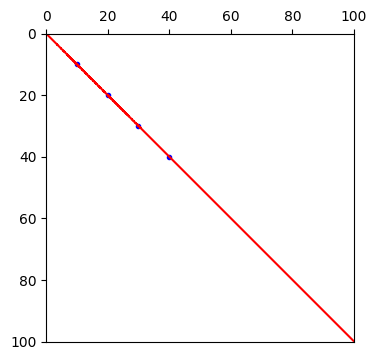

In [10]:
# four points, carefully designed to be on a line
X=np.array([[10,10],
            [20,20],
            [30,30],
            [40,40]])

# data matrix is Nx3 array of homogenous point coordinates
A = in2hom(X)

# singular value decomposition
U,D,VT = np.linalg.svd(A)

# Display diagonal elements of D, and V-transpose.
# Observe that third singular value is zero (up to numerical precision)
print("D = ", D)
print("VT = \n", VT)

# best-fit line is the last row of V-transpose (i.e., last column of V)
l = VT[-1,]

# drawpoints and line in new figure
f,ax = mylineplot(points=X,line=l)

### 1.2.2. One good fit

Now consider the case where the input points are not exactly on a line. In this case the singular values of the data matrix ${\bf A}$ are $(\sigma_1,\sigma_2,\sigma_3)$ are all non-zero.

This means that there is no direction in the model space that gets mapped to zero by the matrix $A$. (Its null space is empty.) We cannot create a zero residual in this case, so we at least try to make the norm $\|\boldsymbol{\varepsilon}\|=0$ as small as possible.

The best direction in model space is still the last row of $V^\top$. Why? Any choice of model ${\bf l}$ will give

\begin{equation}
{\bf D}{\bf V}^\top{\bf l}=
\begin{bmatrix}
\sigma_1 & 0 & 0 \\
0 & \sigma_2 & 0 \\
0 & 0 & \sigma_3 \\
0 & 0 & 0 \\
 & \vdots &
\end{bmatrix}
\begin{bmatrix}
-{\bf v}_1- \\
-{\bf v}_2-  \\
-{\bf v}_3-
\end{bmatrix}
{\bf l}=
\begin{bmatrix}
\sigma_1 & 0 & 0 \\
0 & \sigma_2 & 0 \\
0 & 0 & \sigma_3 \\
0 & 0 & 0 \\
 & \vdots &
\end{bmatrix}
\begin{bmatrix}
w_1 \\
w_2  \\
w_3
\end{bmatrix}=
\begin{bmatrix}
\sigma_1 w_1 \\ \sigma_2 w_3 \\ \sigma_3 w_3 \\ 0 \\ \vdots
\end{bmatrix}
=:\tilde{\boldsymbol{\varepsilon}}
\end{equation}

for some values of $w_1,w_2,w_3$.

The residual vector is $\boldsymbol{\varepsilon}={\bf A}{\bf l}={\bf U}{\bf D}{\bf V}^\top{\bf l}={\bf U}\tilde{\boldsymbol{\varepsilon}}$.

A property of orthogonal matrices like ${\bf U}$ and ${\bf V}$ is that because they only "rotate" vectors, they do not change their norms. This means for example that $\|{\bf U}{\bf z}\|=\|{\bf z}\|$ for any vector ${\bf z}$, and in particular that $\|\boldsymbol{\varepsilon}\|=\|{\bf U}\tilde{\boldsymbol{\varepsilon}}\|=\|\tilde{\boldsymbol{\varepsilon}}\|=\left(\sigma_1^2w_1^2 + \sigma_2^2w_2^2 + \sigma_3^2w_3^2\right)^{1/2}$. It also means that $\|(w_1,w_2,w_3)\|=\|{\bf V}^T{\bf l}\|=1$.

Since the singular values are arranged in decreasing order, $\sigma_1\ge\sigma_2\ge\sigma_3$, the best we can do to reduce the norm of the residual is to choose the model ${\bf l}$ that causes $(w_1,w_2,w_3)=(0,0,1)$, which again is ${\bf l}={\bf v}_3$, the so-called "last column of V".

---
<font color='red'>**To do**</font>: Run the cell and observe that the smallest singular values is much smaller than the other two. Then edit the array `X` in this cell, defining three or more points that do not lie exactly on a line. Re-run the cell to display the line that is fitted to your points. Observe that the third singular value is non-zero, and that its value is indicative of the line's "quality of fit" (in fact, it is equal to the norm of the residual).

D =  [81.58  7.    0.45]
VT = 
 [[-0.72 -0.7  -0.02]
 [-0.69  0.72 -0.1 ]
 [-0.09  0.06  0.99]]


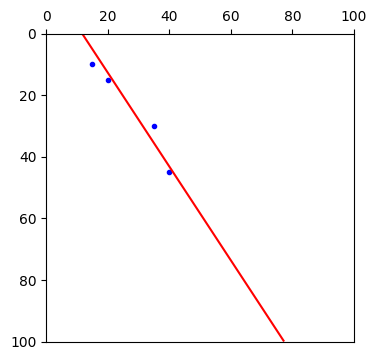

In [11]:
# four points, carefully designed to be on a line
X=np.array([[15,10],
            [20,15],
            [35,30],
            [40,45]])

# data matrix is Nx3 array of homogenous point coordinates
A = in2hom(X)

# singular value decomposition
U,D,VT = np.linalg.svd(A)

# Display diagonal elements of D, and V-transpose.
# Observe that third singular value is zero (up to numerical precision)
print("D = ", D)
print("VT = \n", VT)

# best-fit line is the last row of V-transpose (i.e., last column of V)
l = VT[-1,]

# drawpoints and line in new figure
f,ax = mylineplot(points=X,line=l)

### 1.2.3. Many good fits

It's also possible that the input point-set is "degenerate" in the sense of being insufficient to uniquely determine a  single best-fit line. This happens when all of the points are on top of each other, ${\bf x}_1={\bf x}_2=\ldots={\bf x}_N$.

Singular value decomposition is useful in this situation too. It tells us when it happens, and it provides a good tool to deal with it. The singular values of the data matrix ${\bf A}$ are now $(\sigma_1,0,0)$, with _two_ singular values being zero.

We can achieve a zero residual by choosing any model ${\bf l}$ that is equal to the second or third rows of ${\bf V}^\top$, ${\bf v}_2$ and ${\bf v}_2$, or any model ${\bf l}$ that is a linear combination of the two. In all of these cases we obtain a perfect fit:

\begin{equation}
{\bf D}{\bf V}^\top{\bf l}=
\begin{bmatrix}
\sigma_1 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
 & \vdots &
\end{bmatrix}
\begin{bmatrix}
-{\bf v}_1- \\
-{\bf v}_2-  \\
-{\bf v}_3-
\end{bmatrix}
{\bf l}=
\begin{bmatrix}
\sigma_1 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
 & \vdots &
\end{bmatrix}
\begin{bmatrix}
0 \\
w_2  \\
w_3
\end{bmatrix}=
\begin{bmatrix}
0 \\ 0 \\ 0 \\ 0 \\ \vdots
\end{bmatrix}
\end{equation}

### <font color='red'>**Task 1C**</font>

Run the following cell and observe that the two smallest singular values are zero. Then add a `for` loop at the end of the cell that generates and plots five additional random lines that all fit the degenerate input data points equally well.

_Hint:_ Use `np.random.random()` to generate a random floating point numbers between zero and one.

D =  [113.15   0.     0.  ]
VT = 
 [[-0.71 -0.71 -0.02]
 [ 0.   -0.02  1.  ]
 [ 0.71 -0.71 -0.02]]


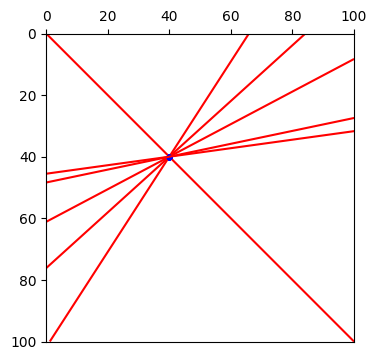

In [12]:
# four points, carefully designed to be co-located
X=np.array([[40,40],
            [40,40],
            [40,40],
            [40,40]])

# data matrix is Nx3 array of homogenous point coordinates
A = in2hom(X)

# singular value decomposition
U,D,VT = np.linalg.svd(A)

# Display diagonal elements of D, and V-transpose.
# Observe that third singular value is zero (up to numerical precision)
print("D = ", D)
print("VT = \n", VT)

# one of the best-fit lines is the last row of V-transpose (i.e., last column of V)
l = VT[-1,]

# draw points and line in new figure
f,ax = mylineplot(points=X,line=l)


# TO DO: WRITE YOUR CODE HERE
# add additional lines to the plot that fit the datapoints equally well
for i in range(5):
    a = np.random.random(1)
    b = np.random.random(1)

    ln = [a,b,-40*(a+b) ]
    mylineplot(points=X,line=ln,axes = ax)

# Section 2. Fitting a conic

A conic in an image is represented by homogeneous vector $\boldsymbol{c}=(a,b,c,d,e,f)$, meaning the collection of points $(x,y)$ that satisfy $x^2+bxy+cy^2+dx+ey+f=0$.

As we did for lines, we can fit a conic model ${\bf c}$ to an input set of $N$ points ${\bf x}_i,i=1\ldots N$. The simplest way to do this is to seek a conic ${\bf c}$ that satisfies $(x_i^2, x_iy_i, y_i^2,x_i,y_i,1)^\top{\bf c}$ for all $i$. In matrix form, this is the conic $\boldsymbol{c}$ that satisfies ${\bf A}_{N\times 6}{\bf c}=\boldsymbol{0}_{N\times 1}$, with matrix ${\bf A}$ being comprised of rows $(x_i^2, x_iy_i, y_i^2,x_i,y_i,1), i=1,\ldots,N$.

If such a vector ${\bf c}$ exists, it is said to be in the _null space_ of matrix ${\bf A}$. If there is no vector satisfying ${\bf A}{\bf c}=\boldsymbol{0}$ exactly, then we at least want to find one that makes all of the elements of the "residual vector" $\boldsymbol{\varepsilon}:={\bf A}\boldsymbol{c}$ as small as possible, in the sense of the sum of their squared values (i.e., the smallest possible norm $\|\boldsymbol{\varepsilon}\|$).

To study this problem, we will use the same learning tool as we sued for line-fitting. Imagine a $100\times 100$ image in which a set of 2D points has been detected and reported by an $N\times 2$ array `X` of their 2D inhomogeneous pixel coordinates. Now you will fit conics to these points instead of lines.

To help visualize these effects, the following cell defines a function

`fig,ax = myconicplot(points=X, line=l, axes=ax)`

that you will use to plot the input points and the fitted conics(s) in an image-like way.

The following cell includes a demonstration of how to use this plotting function to drawing random points and a circle that is centered in the figure.

---
<font color='red'>**To do**</font>: It is not necessary for you to understand what's inside the function, but it is important that you know how to use it.  Run the cell and study the cell's final ten lines of code. Try plotting different conics to get a feel for how it works.

In [13]:
def in2conic_hom(X,Y):
    return np.concatenate([X**2, X*Y, Y**2, X,Y, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)


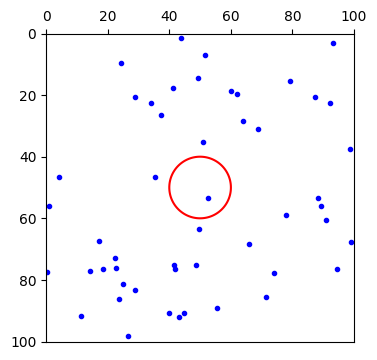

In [14]:
#@title Demonstration: `myconicplot()`

def myconicplot(**kwargs):
    """
    Usage: fig,ax = myconicplot(points=X, line=l, axes=ax, imsize=w)

    Parameters:
      X   -- Nx2 numpy array of inhomogeneous (x,y) point coordinates
      C   -- 1x6 vector of conic parameters (a,b,c,d,e,f)
      ax  -- plt.axes object (if absent, a new figure is created)
      w   -- width of square image in pixels (e.g. 100)

    Returns:
      fig -- matplotlib figure object
      ax  -- matplotlib axes object

    Notes:
      To plot a conic, this function uses the trick of drawing the zero-valued
      contour of the algebraic function $h(x,y)=x^2+bxy+cy^2+dx+ey+f$ using
      matplotlib.pyplot.contour(). Thanks to Modesto Mas for the idea
      (see https://mmas.github.io/conics-matplotlib))
    """

    # if no imsize is provided, set it to 100
    if 'imsize' in kwargs:
        imsize=kwargs.get("imsize")
    else:
        imsize = 100

    # if no axes object provided, create new figure and axes
    if 'axes' in kwargs:
        ax=kwargs.get("axes")
        fig=ax.figure
        ax.set_aspect(aspect=1)
        ax.set_xlim([0, imsize])
        ax.set_ylim([0, imsize])
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    else:
        fig, ax = plt.subplots(figsize=(4,4))

        # make axes "image-like", with origin (0,0) in the top-left corner
        ax.set_aspect(aspect=1)
        ax.set_xlim([0, imsize])
        ax.set_ylim([0, imsize])
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # plot points
    if 'points' in kwargs:
        pts=kwargs.get("points")
        ax.plot(pts[:, 0], pts[:, 1], 'b.')

    # plot conic using zero-value contour of h(x,y)=x^2+bxy+cy^2+dx+ey+f
    if 'conic' in kwargs:
        conic=kwargs.get("conic")
        x,y=np.meshgrid(np.linspace(0,imsize,imsize*5),np.linspace(0,imsize,imsize*5))
        ax.contour(x, y, conic[0]*np.square(x)+conic[1]*np.multiply(x,y)+conic[2]*np.square(y)+conic[3]*x+conic[4]*y +conic[5], [0], colors='r')

    return fig,ax

# define image size
image_width = 100

# 50 random points in square [0,imsize]x[0,imsize]
X = np.random.rand(50, 2) * image_width

# circle centered in imsize with radius imsize/10
#  (derived by (x-xo)^2 + (x-yo)^2 = r^2 ->  x^2 + y^2 - 2xo*x - 2yo*y + (x^2 + yo^2 - r^2) = 0)
c=[1,0,1,-image_width,-image_width,2*(image_width/2)**2-(image_width/10)**2]

# plot points and circle in a new figure
f,ax = myconicplot(points=X, conic=c)

### 2.1. A perfect fit

The data matrix ${\bf A}$ is now $N\times 6$, so the singular value decomposition will be ${\bf U}_{N\times N}{\bf D}_{N\times 6}{\bf V}_{6\times 6}^\top$. As before, the matrices ${\bf U}$ and ${\bf V}$ are orthogonal, so we can focus our attention on minimizing the norm of

\begin{equation}
\tilde{\boldsymbol{\varepsilon}}:=
{\bf D}{\bf V}^\top{\bf c}=
\begin{bmatrix}
\sigma_1 & 0 & 0 & 0 & 0 & 0\\
0 & \sigma_2 & 0 & 0 & 0 & 0\\
0 & 0 & \sigma_3 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_4 & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_5 & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_6\\
0 & 0 & 0 & 0 & 0 & 0\\
 & \vdots &
\end{bmatrix}
\begin{bmatrix}
-{\bf v}_1- \\
-{\bf v}_2-  \\
-{\bf v}_3-  \\
-{\bf v}_4-  \\
-{\bf v}_5-  \\
-{\bf v}_6-
\end{bmatrix}
{\bf c}
\end{equation},

knowing that this is the same as minimizing the norm of residual $\boldsymbol{\varepsilon}={\bf A}{\bf c}$.

Let's start with a situation where $N\ge 6$ and the input points lie exactly on a conic. Can you predict whether any of the singular values $(\sigma_1, \sigma_2,\sigma_3,\sigma_4,\sigma_5,\sigma_6)$ will be zero in this case? Which ones?

### <font color='red'>**Task 2A**</font>

In the following cell, edit the line marked with `# TO DO: REPLACE THIS LINE #` to correctly construct the $N\times 6$ data matrix `A` from the points defined in array `X`. Then run the cell to display the singular values and visualize the fitted conic. Was your prediction about the singular values correct?

D =  [2.13e+04 6.35e+03 1.38e+03 3.20e+01 1.12e+01 6.37e-16]
VT = 
 [[-7.81e-01 -4.99e-01 -3.75e-01 -8.89e-03 -6.06e-03 -1.08e-04]
 [ 5.23e-01 -1.94e-01 -8.30e-01  3.30e-03 -9.11e-03 -6.01e-05]
 [ 3.41e-01 -8.45e-01  4.12e-01  9.53e-03  2.06e-02  7.49e-04]
 [ 1.25e-02 -5.29e-03  6.03e-03 -9.96e-01 -8.23e-02 -1.76e-02]
 [ 6.02e-03 -1.23e-02  1.79e-02  8.31e-02 -9.96e-01 -3.86e-02]
 [ 1.44e-04  1.90e-19  4.00e-04 -1.44e-02 -4.00e-02  9.99e-01]]


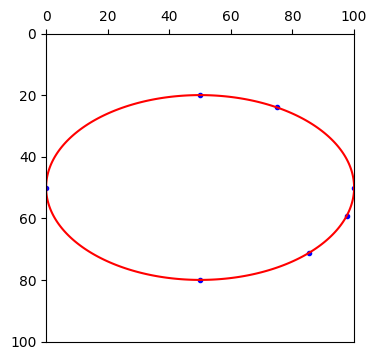

In [15]:
# define image size
image_width = 100

# define seven points, exactly on an ellipse
X=np.array([[50*np.cos(0)+image_width/2,30*np.sin(0)+image_width/2],
            [50*np.cos(np.pi/10)+image_width/2,30*np.sin(np.pi/10)+image_width/2],
            [50*np.cos(np.pi/4)+image_width/2,30*np.sin(np.pi/4)+image_width/2],
            [50*np.cos(np.pi/2)+image_width/2,30*np.sin(np.pi/2)+image_width/2],
            [50*np.cos(np.pi)+image_width/2,30*np.sin(np.pi)+image_width/2],
            [50*np.cos(np.pi*3/2)+image_width/2,30*np.sin(np.pi*3/2)+image_width/2],
            [50*np.cos(np.pi*5/3)+image_width/2,30*np.sin(np.pi*5/3)+image_width/2]])
# TO DO: REPLACE THIS LINE
# build data matrix
A = in2conic_hom(X[:,0].reshape(-1,1), X[:,1].reshape(-1,1))

# singular value decomposition
U,D,VT = np.linalg.svd(A)

# Display diagonal elements of D, and V-transpose.
# Observe that third singular value is zero (up to numerical precision)
print("D = ", D)
print("VT = \n", VT)

# best-fit line is the last row of V-transpose (i.e., last column of V)
c = VT[-1,]

# drawpoints and line in new figure
f,ax = myconicplot(points=X,conic=c)

### 2.2. One good fit

### <font color='red'>**Task 2B**</font>

In the next code cell, edit the two lines marked with `# TO DO: REPLACE THIS LINE` to add noise to the data points `X` by slightly perturbing the pixel coordinates away from the exact ellipse, and to construct the proper data matrix as you did in the task above.

Run the cell several times with different amounts of perturbation noise and observe how the amount of perturbation affects the singular values and quality of fit. Write one or two sentences in the next text cell that describe your observations.

**Observations:** It seems the model is robust enough that for small perturbations of $\pm 10$, the conic algorithm did very fine and the fit curves were almost flawless. Of course, since the points were now not on a conic, it was impossible for the model to fit a conic to it, but the approximations were great. However, as the amount of noise increased, the fit of the model got worse and worse. It got to a point where for a uniform noise with range [-25,25], the conic prediction actually flipped and stopped producing a prediction in the shape of an elipse.  

D =  [2.69e+04 6.87e+03 1.43e+03 3.65e+01 1.02e+01 9.25e-02]
VT = 
 [[-7.59e-01 -5.17e-01 -3.96e-01 -7.71e-03 -5.52e-03 -8.38e-05]
 [ 5.47e-01 -1.78e-01 -8.18e-01  3.19e-03 -8.39e-03 -5.17e-05]
 [ 3.52e-01 -8.37e-01  4.17e-01  1.46e-02  2.35e-02  7.96e-04]
 [ 1.37e-02 -1.07e-02  8.91e-03 -9.91e-01 -1.28e-01 -1.61e-02]
 [ 6.20e-03 -1.41e-02  1.79e-02  1.29e-01 -9.91e-01 -3.84e-02]
 [-1.43e-04  1.01e-04 -4.24e-04  1.11e-02  4.02e-02 -9.99e-01]]


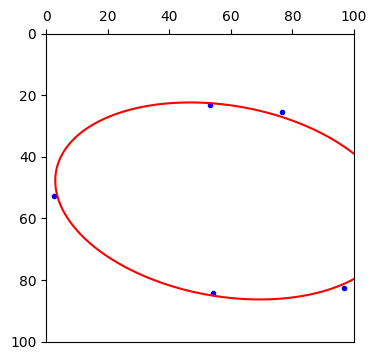

In [16]:
# seven points, carefully designed to be on an ellipse
X=np.array([[50*np.cos(0)+image_width/2, 30*np.sin(0)+image_width/2],
            [50*np.cos(np.pi/10)+image_width/2, 30*np.sin(np.pi/10)+image_width/2],
            [50*np.cos(np.pi/4)+image_width/2, 30*np.sin(np.pi/4)+image_width/2],
            [50*np.cos(np.pi/2)+image_width/2, 30*np.sin(np.pi/2)+image_width/2],
            [50*np.cos(np.pi)+image_width/2, 30*np.sin(np.pi)+image_width/2],
            [50*np.cos(np.pi*3/2)+image_width/2, 30*np.sin(np.pi*3/2)+image_width/2],
            [50*np.cos(np.pi*5/3)+image_width/2, 30*np.sin(np.pi*5/3)+image_width/2]])

# TO DO: REPLACE THIS LINE
# add noise to X
X = X + (np.random.random(len(X))*15).reshape(-1,1)


# TO DO: REPLACE THIS LINE
# build data matrix
A = in2conic_hom(X[:,0].reshape(-1,1), X[:,1].reshape(-1,1))

# singular value decomposition
U,D,VT = np.linalg.svd(A)

# Display diagonal elements of D, and V-transpose.
# Observe that third singular value is zero (up to numerical precision)
print("D = ", D)
print("VT = \n", VT)

# best-fit line is the last row of V-transpose (i.e., last column of V)
c = VT[-1,]

# drawpoints and line in new figure
f,ax = myconicplot(points=X,conic=c)

### 2.3. Many good fits

### <font color='red'>**Task 2C**</font>

In the next code cell, you will make changes to three different parts of the code.

First, edit the first line marked `# TO DO: REPLACE THIS LINE` to generate four image points at random, i.e., an $4\times 2$ numpy array `X1` with values in $[0, 99]$. Then vertically concatenate two copies of this numpy array to create a set of eight datapoints `X` that is $8\times 2$ and includes two co-located datapoints at each of four distinct locations.

Second, edit the line `# TO DO: REPLACE THIS LINE` to properly construct the data matrix, as you did in the two previous tasks.

Run the cell several times and observe the singular values. Write a paragraph in the next text cell that that describes and explains how many singular values there are and why.

Finally, as you did in Section 1 above, add a `for` loop to the bottom of the cell to generate multiple distinct conics that fit the input points. Display these conics overlaid in the same figure.

**Observations:** _TO DO: Write your observations here_

(4, 2)
(8, 2)
D =  [1.90e+04 6.38e+03 6.88e+02 2.17e+01 5.82e-14 2.52e-16]
VT = 
 [[-5.83e-01 -5.43e-01 -6.04e-01 -8.38e-03 -8.79e-03 -1.35e-04]
 [ 6.79e-01  8.24e-02 -7.29e-01  5.09e-03 -7.69e-03 -5.85e-05]
 [ 4.45e-01 -8.35e-01  3.20e-01  3.75e-02  3.73e-02  1.34e-03]
 [ 2.15e-02 -3.20e-02  2.52e-02 -2.11e-01 -9.76e-01 -3.04e-02]
 [-2.10e-02  2.01e-02 -8.24e-03  9.77e-01 -2.12e-01 -1.00e-02]
 [-1.91e-04  2.73e-04  1.33e-04  3.34e-03 -3.19e-02  9.99e-01]]


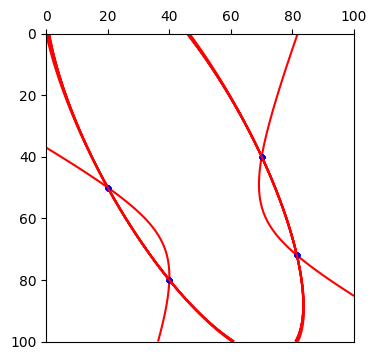

In [25]:
# TO DO: REPLACE THIS LINE
# Create eight datapoints, with two datapoints co-located at each of four random locations
X=np.array([[40, 30+ image_width/2],
            [20, image_width/2],
            [10*math.pi+image_width/2, 7*math.pi +image_width/2],
            [70,40]])
print(X.shape)

X = np.vstack((X,X))
print(X.shape)
# TO DO: REPLACE THIS LINE
# build data matrix
A = in2conic_hom(X[:,0].reshape(-1,1), X[:,1].reshape(-1,1))

# singular value decomposition
U,D,VT = np.linalg.svd(A)

# Display diagonal elements of D, and V-transpose.
# Observe that third singular value is zero (up to numerical precision)
print("D = ", D)
print("VT = \n", VT)

# best-fit line is the last row of V-transpose (i.e., last column of V)
c = VT[-1,]

LV1 = VT[-2,]
# drawpoints and line in new figure
f,ax = myconicplot(points=X,conic=c)
myconicplot(points=X,conic=LV1, axes=ax)
# TO DO: WRITE YOUR CODE HERE
# add additional conics to the plot that fit the datapoints equally well
for i in range(6):
    rand = np.random.random()*15
    myconicplot(points=X,conic=LV1*rand+c*(1-rand), axes=ax)
    


<a name="ai-disclosure"></a>
# Disclosure of use of Generative AI for this assignment

NONE



<a name="submission"></a>
# Submission

The following cell generates an HTML export of your notebook in the folder `es-143-assignments/M05/submit` on your Google Drive. Once it is generated, submit your `.html` export and a copy of your `.ipynb` file to the appropriate assignment on Canvas. Your submissions should use filenames `LASTNAME_FIRSTNAME_M05-ModelFitting-SVD.{html,ipynb}`.

**Important**:
1. Before you submit, verify that the images in your HTML have been correctly rendered. If they are not, re-run your notebook and re-run the cell below.
2. Remember to edit the filenames (either in the cells below or on your local computer after downloading) to match your name, and make sure that all cells execute properly (i.e., click Runtime -> Restart session and run all) before exporting to HTML.


In [18]:
!mkdir "submit"

In [19]:
# Convert to HTML. Before running this cell:
# 1. edit your name in this cell
# 2. make sure your notebook executes and is saved

!jupyter nbconvert --to html 5_ModelFitting_SVD.ipynb --output-dir "submit" --output "SADIK_SEDIK_M05-ModelFitting-SVD.html"

[NbConvertApp] Converting notebook 5_ModelFitting_SVD.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 612417 bytes to submit/SADIK_SEDIK_M05-ModelFitting-SVD.html
